# Evaluations For Multi-Class Classification Models

This workflow, part of our [MLOps](../readme.md) series that dives into [Model Evaluation](./readme.md), provides a comprehensive, end-to-end example of building and evaluating a machine learning model directly within Google Cloud's Vertex AI ecosystem.

Specifically, this guide will walk you through how to:

* **Prepare Data at Scale:** Begin by exploring and efficiently preparing a large public dataset sourced from **BigQuery**, demonstrating how to leverage both powerful **SQL** queries and the interactive **BigFrames API** (pandas interface) for machine learning data readiness.
* **Build Robust Models with Scikit-learn:** Construct a complete **Scikit-learn model pipeline** that seamlessly integrates additional feature engineering steps with the training of a classification model.
* **Register Models in Vertex AI:** Master the crucial MLOps step of saving your trained model and **registering it as a version within the Vertex AI Model Registry** for centralized management and version control.
* **Generate & Upload Custom Metrics:** Delve into preparing **custom, detailed evaluation metrics** using **Scikit-learn**, and then strategically **load these results to your versioned model in the Vertex AI Model Registry**. This includes showcasing how to generate and upload metrics for specific **data slices** to gain granular performance insights.
* **Review & Retrieve Evaluations:** Conclude by learning how to easily **review and programmatically retrieve these comprehensive evaluation results** directly from the Model Registry UI and via the **Vertex AI SDK**, empowering you to effectively track and compare model performance over time.


---
## Colab Setup

To run this notebook in Colab run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Installs

The list `packages` contains tuples of package import names and install names.  If the import name is not found then the install name is used to install quitely for the current user.

In [27]:
# tuples of (import name, install name, min_version)
packages = [
    ('bigframes', 'bigframes'),
    ('sklearn', 'scikit-learn'),
    ('numpy', 'numpy'),
    ('google.cloud.aiplatform', 'google-cloud-aiplatform'), 
    ('google.cloud.storage', 'google-cloud-storage'),
    ('google.cloud.bigquery', 'google-cloud-bigquery'),
    ('bigquery_magics', 'bigquery-magics'),
    ('matplotlib', 'matplotlib')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

### API Enablement

In [5]:
!gcloud services enable aiplatform.googleapis.com

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [6]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)
    IPython.display.display(IPython.display.Markdown("""<div class=\"alert alert-block alert-warning\">
        <b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. The previous cells do not need to be run again⚠️</b>
        </div>"""))

---
## Setup

inputs:

In [7]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [8]:
REGION = 'us-central1'
SERIES = 'mlops'
EXPERIMENT = 'evaluation-classification-multi-class'

# Set the name of GCS Bucket to read/write to
GCS_BUCKET = PROJECT_ID

# Data source for this workflow
BQ_SOURCE = 'bigquery-public-data.ml_datasets.penguins'

# make this the BigQuery Project / Dataset / Table prefix to store results
BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-', '_')
BQ_TABLE = EXPERIMENT
BQ_REGION = REGION[0:2] # use a multi region

packages:

In [41]:
import os
import joblib
import sklearn.metrics
import sklearn.ensemble
import sklearn.pipeline
import sklearn.compose
import sklearn.preprocessing
import sklearn.impute
import numpy as np
import matplotlib.pyplot as plt

import bigframes.pandas as bpd
from google.cloud import aiplatform
from google.cloud import bigquery
from google.cloud import storage

clients:

In [20]:
# vertex ai clients
aiplatform.init(project = PROJECT_ID, location = REGION, experiment = SERIES+'-'+EXPERIMENT)

# gcs storage client
gcs = storage.Client(project = GCS_BUCKET)
bucket = gcs.bucket(GCS_BUCKET)

# bigquery client
bq = bigquery.Client(project = PROJECT_ID)

# bigframes setup
bpd.options.bigquery.project = PROJECT_ID

# bigquery cell magics load
%load_ext bigquery_magics

Parameters:

In [11]:
DIR = f"files/{EXPERIMENT}"

Environment:

In [12]:
if not os.path.exists(DIR):
    os.makedirs(DIR)

---
## Review Data Source: Palmer Penguins

This project will uses the following data source as a tutorial.  It is good for examples like this because it is small, has few columns, but contains categorial and numerical data types.

The source table is a BigQuery Public Dataset table.  The following cell uses the [BigQuery IPython magic](https://cloud.google.com/python/docs/reference/bigquery/latest/magics) to retrieve 5 rows of the table for review.  This data is known as [Palmer Penguins](https://allisonhorst.github.io/palmerpenguins/) data: 

```
@Manual{,
  title = {palmerpenguins: Palmer Archipelago (Antarctica) penguin data},
  author = {Allison Marie Horst and Alison Presmanes Hill and Kristen B Gorman},
  year = {2020},
  note = {R package version 0.1.0},
  doi = {10.5281/zenodo.3960218},
  url = {https://allisonhorst.github.io/palmerpenguins/},
}
```


There are 334 observations of 4 numerical features (culman length, culmen depth, flipper length, body mass) and 2  categorical features (island, sex) that represent 3 species of penguins.

### Review BigQuery table:

Use the [BigQuery BigFrames](https://cloud.google.com/bigquery/docs/use-bigquery-dataframes) package, setup above, to treat BigQuery tables like dataframes.  This has the advantage of doing the computing within BigQuery rather than pulling the data locally.

In [13]:
source_data = bpd.read_gbq(BQ_SOURCE)
source_data.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Gentoo penguin (Pygoscelis papua),Biscoe,45.2,16.4,223.0,5950.0,MALE
1,Gentoo penguin (Pygoscelis papua),Biscoe,46.5,14.5,213.0,4400.0,FEMALE
2,Adelie Penguin (Pygoscelis adeliae),Biscoe,37.7,16.0,183.0,3075.0,FEMALE
3,Gentoo penguin (Pygoscelis papua),Biscoe,46.4,15.6,221.0,5000.0,MALE
4,Gentoo penguin (Pygoscelis papua),Biscoe,46.1,13.2,211.0,4500.0,FEMALE


In [ ]:
source_data.info()

<class 'bigframes.dataframe.DataFrame'>
Index: 113500316 entries, 0 to 113500315
Data columns (total 20 columns):
  #  Column               Dtype
---  -------------------  ------------------------------
  0  vendor_id            string
  1  pickup_datetime      timestamp[us, tz=UTC][pyarrow]
  2  dropoff_datetime     timestamp[us, tz=UTC][pyarrow]
  3  passenger_count      Int64
  4  trip_distance        decimal128(38, 9)[pyarrow]
  5  rate_code            string
  6  store_and_fwd_flag   string
  7  payment_type         string
  8  fare_amount          decimal128(38, 9)[pyarrow]
  9  extra                decimal128(38, 9)[pyarrow]
 10  mta_tax              decimal128(38, 9)[pyarrow]
 11  tip_amount           decimal128(38, 9)[pyarrow]
 12  tolls_amount         decimal128(38, 9)[pyarrow]
 13  imp_surcharge        decimal128(38, 9)[pyarrow]
 14  airport_fee          decimal128(38, 9)[pyarrow]
 15  total_amount         decimal128(38, 9)[pyarrow]
 16  pickup_location_id   string
 17  drop

In [17]:
source_data.describe(include = 'all')

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
count,344,344,342.0,342.0,342.0,342.0,334
nunique,3,3,<NA>,<NA>,<NA>,<NA>,3
mean,<NA>,<NA>,43.92193,17.15117,200.915205,4201.754386,<NA>
std,<NA>,<NA>,5.459584,1.974793,14.061714,801.954536,<NA>
min,<NA>,<NA>,32.1,13.1,172.0,2700.0,<NA>
25%,<NA>,<NA>,39.2,15.5,190.0,3550.0,<NA>
50%,<NA>,<NA>,44.1,17.3,197.0,4000.0,<NA>
75%,<NA>,<NA>,48.5,18.7,213.0,4750.0,<NA>
max,<NA>,<NA>,59.6,21.5,231.0,6300.0,<NA>


### Understand The Data Source With `ML.DESCRIBE_DATA`

Reviewing a few records, like above, gives a good sense of how the data is arranged. Before proceeding with machine learning techniques it is important to understand more about these raw columns.  Are they ready to use a features in a model or is some form of feature engineering needed first?  For this, the distribution of values is an important starting point.  

While SQL could be used to look at the distribution, it would be a time consuming process and requires different techniques for different data types like numerical, string, boolean, dates, times, array and struct version of these, and arrays of structs.

To make this process fast and simple, the new [`ML.DESCRIBE_DATA`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-describe-data) function is used to get a single row for each column the describes the data distribution:
- `top_k`: get the top 3 most frequent categories for string columns (default = 1)
- `num_quantiles`: get 4 quantiles for numerical columns (default = 2)

In [29]:
%%bigquery
SELECT *
FROM ML.DESCRIBE_DATA(
    TABLE `bigquery-public-data.ml_datasets.penguins`,
    STRUCT(3 as top_k, 4 as num_quantiles)
)

/home/statmike/repos/vertex-ai-mlops/MLOps/.venv/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:2074: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type, max_results=max_results)
/home/statmike/repos/vertex-ai-mlops/MLOps/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2645: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,name,num_rows,num_nulls,num_zeros,min,max,mean,stddev,median,quantiles,unique,avg_string_length,num_values,top_values,min_array_length,max_array_length,avg_array_length,total_array_length,array_length_quantiles,dimension
0,body_mass_g,344,2,0,2700,6300,4201.754386,800.781229,4000.0,"[2700.0, 3550.0, 4000.0, 4750.0, 6300.0]",<NA>,NaN,342,[],<NA>,<NA>,NaN,<NA>,[],<NA>
1,culmen_depth_mm,344,2,0,13.1,21.5,17.151170,1.971904,17.3,"[13.1, 15.6, 17.3, 18.7, 21.5]",<NA>,NaN,342,[],<NA>,<NA>,NaN,<NA>,[],<NA>
2,culmen_length_mm,344,2,0,32.1,59.6,43.921930,5.451596,44.4,"[32.1, 39.2, 44.4, 48.5, 59.6]",<NA>,NaN,342,[],<NA>,<NA>,NaN,<NA>,[],<NA>
3,flipper_length_mm,344,2,0,172,231,200.915205,14.041141,197.0,"[172.0, 190.0, 197.0, 213.0, 231.0]",<NA>,NaN,342,[],<NA>,<NA>,NaN,<NA>,[],<NA>
4,island,344,0,<NA>,Biscoe,Torgersen,NaN,NaN,NaN,[],3,6.093023,344,"[{'value': 'Biscoe', 'count': 168}, {'value': ...",<NA>,<NA>,NaN,<NA>,[],<NA>
5,sex,344,10,<NA>,.,MALE,NaN,NaN,NaN,[],3,4.979042,334,"[{'value': 'MALE', 'count': 168}, {'value': 'F...",<NA>,<NA>,NaN,<NA>,[],<NA>
6,species,344,0,<NA>,Adelie Penguin (Pygoscelis adeliae),Gentoo penguin (Pygoscelis papua),NaN,NaN,NaN,[],3,35.465116,344,[{'value': 'Adelie Penguin (Pygoscelis adeliae...,<NA>,<NA>,NaN,<NA>,[],<NA>


Some observations:
- All columns have `num_rows` and `num_nulls`
- Numerical columns have `min`, `max`, `stddev`, `median`, and `quantiles` showing the distribution of the data in the column
- Categorical (string) columns have `min`, `max` values representing the class levels and a `unique` column show how many class levels

Data quality observation:
- The column `sex` has both missing values (10 indicated in `num_nulls`) as well as a `min` values of `.`.  This appears to be a data quality issue that needs fixing.

---
## Prepare Data Source

The data preparation includes adding splits for machine learning with a column named `splits` with values for training (`TRAIN`), validation (`VALIDATE`), and for testing (`TEST`).  Additionally, a unique identifier was added to each record, `penguin_id`. 

>These steps could be done locally at training but are instead done in the source system, BigQuery in this case, which provides several advantages:
>
>-   **Single Source of Truth:** A single data preparation can benefit multiple model training jobs for different architectures or even different team members working on the same model. This ensures consistency and avoids duplication of effort.
>-   **Leverage BigQuery's Power:** BigQuery is highly optimized for large-scale data processing. Performing these operations directly in BigQuery leverages its distributed processing capabilities, making the preparation significantly faster and more efficient than local processing, especially for massive datasets.
>-   **Reduced Data Movement:** Preparing the data in BigQuery reduces the amount of data that needs to be moved out of BigQuery and into the training environment. This minimizes latency and potential bottlenecks associated with data transfer.
>-   **Data Versioning and Reproducibility:** By preparing the splits and unique ID in BigQuery, the specific dataset used for training can be easily tracked and versioned. This enhances the reproducibility of experiments and makes it easier to understand the provenance of the data used in a particular model.
>-   **Simplified Training Pipeline:** The training pipeline becomes simpler because it can directly read pre-split data from BigQuery, eliminating the need for complex splitting logic within the training code.
>-   **Pre-calculated Joins and Features:** BigQuery can be used to pre-calculate joins and engineer new features that are beneficial for the model. This can improve model performance and further reduce the workload during the training phase.
>
>**Further Considerations:**
>
>-   **Data Governance and Security:** BigQuery offers robust data governance and security features. Performing data preparation within BigQuery allows you to maintain control over access and ensure data quality.
>-   **Scalability:** This approach is highly scalable. As your dataset grows, BigQuery can handle the increased workload without requiring significant changes to your data preparation pipeline.
>-   **Cost Optimization:** While moving large amounts of data out of BigQuery can incur costs, performing the preparation steps within BigQuery and only extracting the necessary data for training can often be more cost-effective.
>
>By preparing the data in BigQuery, you create a streamlined, efficient, and reproducible workflow (pipeline) that leverages the strengths of the platform and sets your machine learning models up for success.


### Create/Recall Dataset

In [15]:
dataset = bigquery.Dataset(f"{BQ_PROJECT}.{BQ_DATASET}")
dataset.location = BQ_REGION
bq_dataset = bq.create_dataset(dataset, exists_ok = True)

### Create/Recall Table With Preparation For ML

Copy the data from the source while adding and correcting columns:
- Apply a correction to the data quality issue identified for the `sex` column with values of `.` as Null values.
- `penguin_id` as a unique identify for the row
    - Use the `GENERATE_UUID()` function
- `splits` column to randomly assign rows to 'TRAIN", "VALIDATE" and "TEST" groups
    - stratified sampling within the levels of `class` by first assigning row numbers within the levels of `class` then using the with a CASE statment to assign the `splits` level.

In [31]:
job = bq.query(f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` AS
WITH
    base_data AS (
        SELECT
            -- Features
            island,
            species, -- Target variable
            culmen_length_mm,
            culmen_depth_mm,
            flipper_length_mm,
            body_mass_g,
            CASE WHEN sex = '.' THEN NULL ELSE sex END AS sex,

            -- Add an ID for unique identification
            GENERATE_UUID() AS penguin_id,

            ROW_NUMBER() OVER (PARTITION BY species ORDER BY RAND()) as rn
        FROM `{BQ_SOURCE}`
        # WHERE
    )
SELECT
    * EXCEPT(rn),
    CASE -- 80% for train, 10% for validation, 10% for test
        WHEN rn <= .8 * COUNT(*) OVER (PARTITION BY species) THEN 'TRAIN'
        WHEN rn <= .9 * COUNT(*) OVER (PARTITION BY species) THEN 'VALIDATE'
        WHEN rn <= 1 * COUNT(*) OVER (PARTITION BY species) THEN 'TEST'
        ELSE Null -- records not sampled for using in training here
    END AS splits
FROM
    base_data
""")
job.result()
(job.ended-job.started).total_seconds()

43.172

In [32]:
source_data_prepared = bpd.read_gbq(f"{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}", use_cache = False)
source_data_prepared.head()

,island,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,penguin_id,splits
0,Biscoe,Gentoo penguin (Pygoscelis papua),48.1,15.1,209.0,5500.0,MALE,79d7df9a-3c41-4ff9-b124-0ae175046300,TRAIN
1,Biscoe,Gentoo penguin (Pygoscelis papua),49.2,15.2,221.0,6300.0,MALE,d00c843a-7cd1-4b67-8c59-5d81e17ffd7d,TRAIN
2,Torgersen,Adelie Penguin (Pygoscelis adeliae),39.5,17.4,186.0,3800.0,FEMALE,e9e09a23-b8eb-4fed-8563-d6a9e0aa18c1,TRAIN
3,Biscoe,Adelie Penguin (Pygoscelis adeliae),37.7,16.0,183.0,3075.0,FEMALE,a05a1570-fe1f-4979-9483-2e7257290b73,TRAIN
4,Biscoe,Gentoo penguin (Pygoscelis papua),43.4,14.4,218.0,4600.0,FEMALE,9a717d5e-4b78-45bc-a28e-452973da95c6,TRAIN


### Review the number of records for each level of `species` for each of the data splits:

In [34]:
bq.query(f"""
SELECT splits, species,
    count(*) as count,
    ROUND(count(*) * 100.0 / SUM(count(*)) OVER (PARTITION BY species), 2) AS percentage
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
GROUP BY splits, species
ORDER BY species, splits
""").to_dataframe()

,splits,species,count,percentage
0,TEST,Adelie Penguin (Pygoscelis adeliae),16,10.53
1,TRAIN,Adelie Penguin (Pygoscelis adeliae),121,79.61
2,VALIDATE,Adelie Penguin (Pygoscelis adeliae),15,9.87
3,TEST,Chinstrap penguin (Pygoscelis antarctica),7,10.29
4,TRAIN,Chinstrap penguin (Pygoscelis antarctica),54,79.41
5,VALIDATE,Chinstrap penguin (Pygoscelis antarctica),7,10.29
6,TEST,Gentoo penguin (Pygoscelis papua),13,10.48
7,TRAIN,Gentoo penguin (Pygoscelis papua),99,79.84
8,VALIDATE,Gentoo penguin (Pygoscelis papua),12,9.68


### Further Data Preparation



#### Rows Assigned To A Split (TRAIN, TEST, VALIDATE)

Avoid the unsampled rows where `splits = Null`:

In [35]:
# only use rows assigned to a split:
source_data_prepared_filtered = source_data_prepared[source_data_prepared['splits'].notna()]

#### Group Columns By Type

In [36]:
# Numerical columns
numerical_cols = [
    'culmen_length_mm',
    'culmen_depth_mm',
    'flipper_length_mm',
    'body_mass_g'
]

# Categorical columns
categorical_cols = [
    'sex',
    'island'
]

target_col = 'species'
split_col = 'splits'
id_col = 'penguin_id' # Keep id for later lookup if needed, but not as a feature

#### Check For Columns With NaNs

In [37]:
source_data_prepared_filtered[numerical_cols + categorical_cols + [target_col]].isna().sum()

culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  11
island                0
species               0
dtype: Int64

#### Setup Pointers For Training

In [38]:
X_frame = source_data_prepared_filtered[numerical_cols + categorical_cols]
y_frame = source_data_prepared_filtered[target_col]
splits_frame = source_data_prepared_filtered[split_col]

print(f"There are {X_frame.shape[0]} training rows for {X_frame.shape[1]} raw features.")
print(f"Confirming the rows for splits and the label are {splits_frame.shape[0]} and {y_frame.shape[0]} respectively.")

There are 344 training rows for 6 raw features.
Confirming the rows for splits and the label are 344 and 344 respectively.


---
## Train With Scikit-Learn

### Local Dataframes

Convert the Bigframes pointers to Pandas dataframes for the training objects:

In [39]:
X_train = X_frame[splits_frame == 'TRAIN'].to_pandas()
X_val = X_frame[splits_frame == 'VALIDATE'].to_pandas()
X_test = X_frame[splits_frame == 'TEST'].to_pandas()

y_train = y_frame[splits_frame == 'TRAIN'].to_pandas()
y_val = y_frame[splits_frame == 'VALIDATE'].to_pandas()
y_test = y_frame[splits_frame == 'TEST'].to_pandas()

In [40]:
X_train.shape, y_train.shape

((274, 6), (274,))

In [50]:
for col in numerical_cols:
    X_train[col] = X_train[col].astype(float)
    X_val[col] = X_val[col].astype(float)
    X_test[col] = X_test[col].astype(float)

for col in categorical_cols:
    # Convert to object dtype to ensure consistent string/object behavior, then fill any pd.NA
    X_train[col] = X_train[col].astype('object').fillna('__MISSING__')
    X_val[col] = X_val[col].astype('object').fillna('__MISSING__')
    X_test[col] = X_test[col].astype('object').fillna('__MISSING__')

### Define A Preprocessor

Create a Scikit-Learn preprocessor that standardizes numeric variables and one-hot encodes categorical variables:

In [51]:
preprocessor = sklearn.compose.ColumnTransformer(
    transformers = [
        # Apply StandardScaler to numerical columns
        ('num', sklearn.pipeline.Pipeline(
            steps = [
                ('imputer', sklearn.impute.SimpleImputer(strategy = 'median')),
                ('scaler', sklearn.preprocessing.StandardScaler())
            ]
        ), numerical_cols),
        # Apply OneHotEncoder to categorical columns
        ('cat', sklearn.pipeline.Pipeline(
            steps = [
                ('imputer', sklearn.impute.SimpleImputer(strategy = 'most_frequent')),
                ('encoder', sklearn.preprocessing.OneHotEncoder(handle_unknown = 'ignore', sparse_output = False))
            ]
        ), categorical_cols),
    ],
    remainder = 'passthrough' # Keep any other columns not explicitly listed (if any) as they are
)

### Define A Model Pipeline: Proprocessor + Model

Combine the preprocessor with the model type in a pipeline:

In [52]:
model_pipeline = sklearn.pipeline.Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('classifier', sklearn.ensemble.GradientBoostingClassifier(
            n_estimators=100,    # You can tune this
            learning_rate=0.1,   # You can tune this
            max_depth=3,         # Crucial for size and speed with GBTs
            random_state=42      # For reproducibility
        ))
    ]
)

### Train/Fit The Model

Use the training data to train the model using the pipeline:

In [53]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['culmen_length_mm',
                                                   'culmen_depth_mm',
                                                   'flipper_length_mm',
                                                   'body_mass_g']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['sex', 'island'])])),
                ('classifier', GradientBoostingClassifier(random_state=42))])

---
## Evaluate The Model

Use the [Scikit-Learn metrics](https://scikit-learn.org/stable/api/sklearn.metrics.html) module to get evaluation metrics for the model on the data splits.

In [54]:
y_pred_proba_test = model_pipeline.predict_proba(X_test) # Multi-class predict_proba returns (n_samples, n_classes)
y_pred_class_test = model_pipeline.predict(X_test) # Predicted class labels

In [55]:
class_labels = model_pipeline.named_steps['classifier'].classes_.tolist()
print(f"Model's learned class labels: {class_labels}")

Model's learned class labels: ['Adelie Penguin (Pygoscelis adeliae)', 'Chinstrap penguin (Pygoscelis antarctica)', 'Gentoo penguin (Pygoscelis papua)']


In [56]:
test_accuracy = sklearn.metrics.accuracy_score(y_test, y_pred_class_test)
test_roc_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_proba_test)
test_log_loss = sklearn.metrics.log_loss(y_test, y_pred_proba_test)

print(f"Accuracy (TEST): {test_accuracy:.4f}")
print(f"ROC AUC (TEST): {test_roc_auc:.4f}")
print(f"Log Loss (TEST): {test_log_loss:.4f}")

ValueError: multi_class must be in ('ovo', 'ovr')

In [57]:
print("\nClassification Report (TEST Split):")
print(sklearn.metrics.classification_report(y_test, y_pred_class_test))


Classification Report (TEST Split):
                                           precision    recall  f1-score   support

      Adelie Penguin (Pygoscelis adeliae)       0.94      1.00      0.97        16
Chinstrap penguin (Pygoscelis antarctica)       1.00      0.86      0.92         7
        Gentoo penguin (Pygoscelis papua)       1.00      1.00      1.00        13

                                 accuracy                           0.97        36
                                macro avg       0.98      0.95      0.96        36
                             weighted avg       0.97      0.97      0.97        36



In [58]:
print("\nConfusion Matrix (TEST Split):")
print(sklearn.metrics.confusion_matrix(y_test, y_pred_class_test))


Confusion Matrix (TEST Split):
[[16  0  0]
 [ 1  6  0]
 [ 0  0 13]]


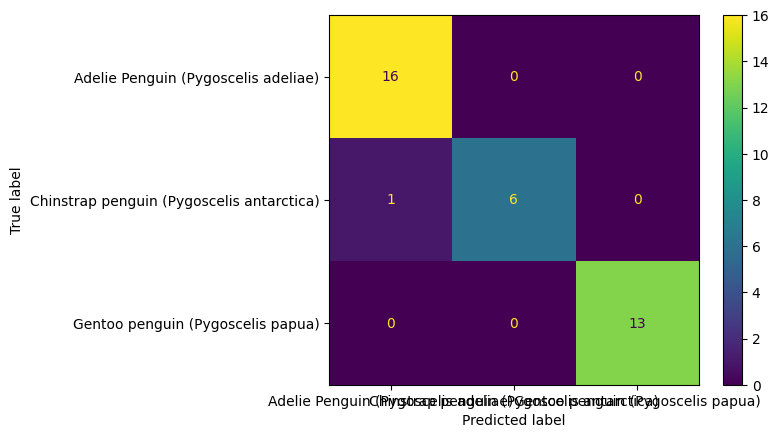

In [60]:
disp = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred_class_test),
    display_labels = class_labels
)
disp.plot()